# Detecção de inundação com Deep Learning (Finetuning MobileNet, KERAS)

In [1]:
# Importar bibliotecas e funções necessárias
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [2]:
# Carregar dados e pré-processar imagens de acordo com os requisitos do mobilenet
# Criar lotes de dados

labels = ['INUNDAÇÃO', 'Sem inundação']
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 321 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [3]:
#Carregar lightweight mobilenet image classifier
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)
# mobile.summary()

In [4]:
# Armazenar todas as layers da rede móvel original, exceto as últimas 5 camadas na variável x
# Não há lógica predefinida por trás disso, apenas fornece os resultados ideais para esta tarefa
# Além disso, estaremos treinando apenas as últimas 12 camadas da rede móvel durante o ajuste fino como queremos
# para manter todos os pesos aprendidos anteriormente
x = mobile.layers[-12].output
x

<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'conv_dw_12')>

In [5]:
# Criar global pooling, dropout e uma camada de saída binária, pois queremos que nosso modelo seja um classificador binário,
# ou seja, para classificar com inundação e sem inundação
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [6]:
# Construir o novo modo de ajuste fino
model = Model(inputs=mobile.input, outputs=output)

In [7]:
# Congele os pesos de todas as camadas, exceto as últimas cinco camadas no nosso novo modelo,
# o que significa que apenas as últimas 12 camadas do modelo serão treinadas.
for layer in model.layers[:-23]:
    layer.trainable = False

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, None, None, 512)  4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, None, None, 512)  2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, None, None, 512)   0         
                                                                 
 conv_pw_9 (Conv2D)          (None, None, None, 512)   262144    
                                                                 
 conv_pw_9

In [9]:
# Compilar o modelo
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10


C:\DevTools\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


33/33 - 8s - loss: 1.2423 - accuracy: 0.7695 - val_loss: 0.1801 - val_accuracy: 0.9630 - 8s/epoch - 240ms/step
Epoch 2/10
33/33 - 6s - loss: 0.1828 - accuracy: 0.9283 - val_loss: 0.3842 - val_accuracy: 0.8889 - 6s/epoch - 185ms/step
Epoch 3/10
33/33 - 6s - loss: 0.2297 - accuracy: 0.9564 - val_loss: 0.2351 - val_accuracy: 0.9383 - 6s/epoch - 182ms/step
Epoch 4/10
33/33 - 6s - loss: 0.2846 - accuracy: 0.9439 - val_loss: 0.2396 - val_accuracy: 0.9259 - 6s/epoch - 181ms/step
Epoch 5/10
33/33 - 6s - loss: 0.0806 - accuracy: 0.9782 - val_loss: 0.5859 - val_accuracy: 0.9383 - 6s/epoch - 186ms/step
Epoch 6/10
33/33 - 6s - loss: 0.1104 - accuracy: 0.9626 - val_loss: 0.2980 - val_accuracy: 0.9753 - 6s/epoch - 178ms/step
Epoch 7/10
33/33 - 6s - loss: 0.0361 - accuracy: 0.9875 - val_loss: 0.2427 - val_accuracy: 0.9506 - 6s/epoch - 186ms/step
Epoch 8/10
33/33 - 6s - loss: 0.0588 - accuracy: 0.9938 - val_loss: 0.1771 - val_accuracy: 0.9753 - 6s/epoch - 188ms/step
Epoch 9/10
33/33 - 6s - loss: 0.012

In [11]:
# Guardar e carregar o novo modelo treinado para uso futuro

model.save("modelo_inundacao_por_imagem")
# model.load_weights('modelo_inundacao_por_imagem')

INFO:tensorflow:Assets written to: modelo_inundacao_por_imagem\assets


INFO:tensorflow:Assets written to: modelo_inundacao_por_imagem\assets


In [12]:
# Fazer previsões e mostrar a matriz de confusão para ver o desempenho do modelo na classificação
# de imagens de inundação e sem inundacao

test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# Pring precision, F1 score e accuracy do modelo
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9642857142857143
F1 Score:  0.9642857142857143
Accuracy:  0.971830985915493


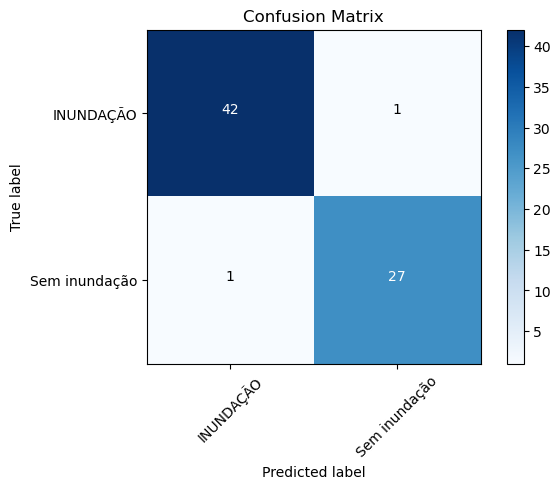

In [14]:
# matriz de confusão
test_batches.class_indices
cm_plot_labels = ['INUNDAÇÃO', 'Sem inundação']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Avaliar o modelo

In [15]:
# Preparar imagem para previsão de mobilenet

def preprocess_image(file):
    img_path = 'evaluate/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

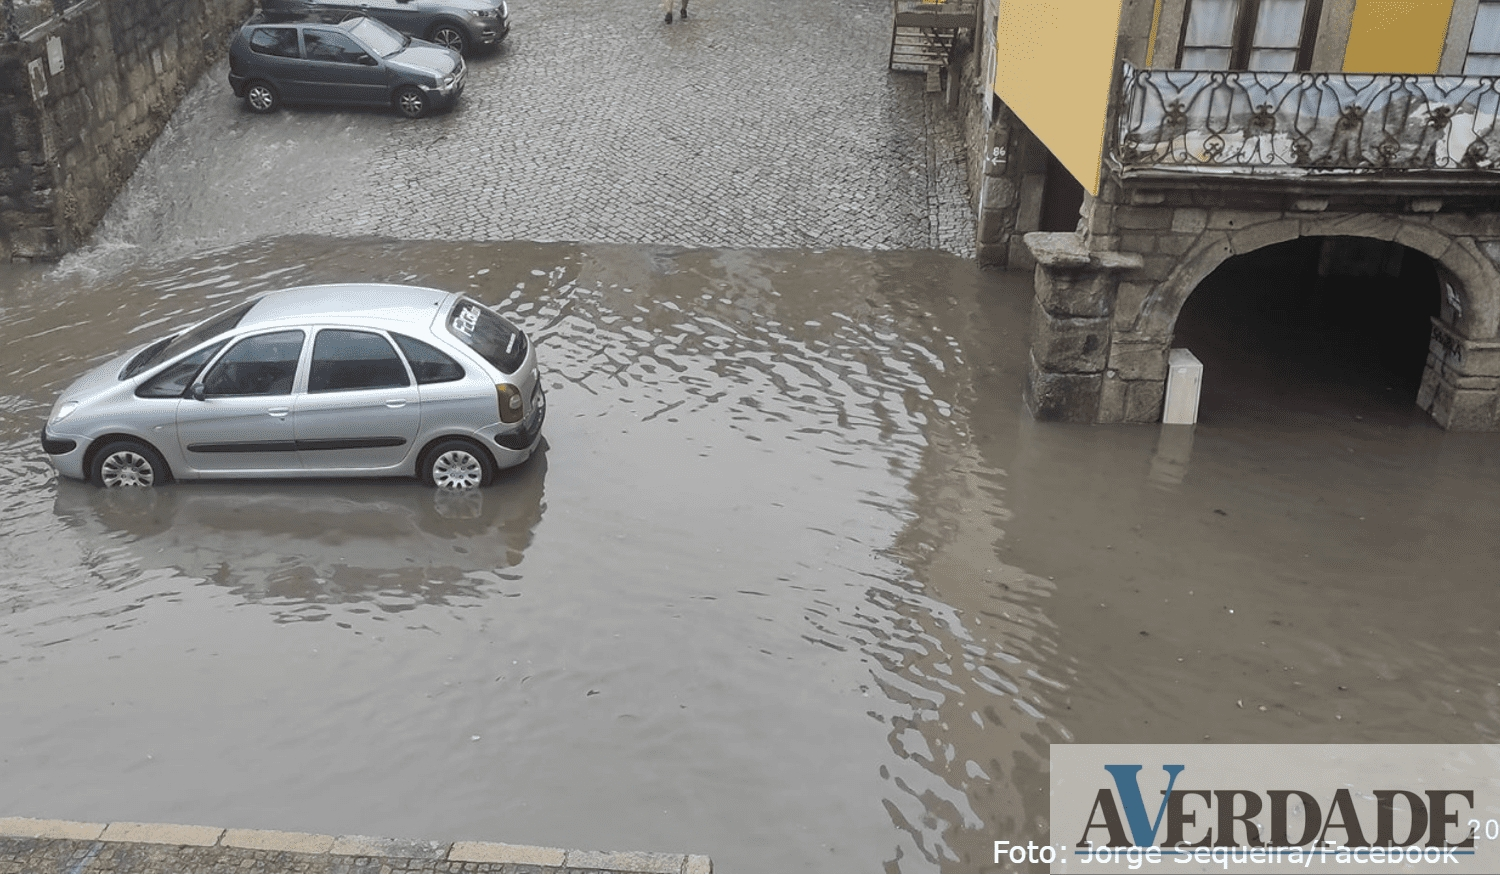

In [21]:
# Mostrar imagem que queremos prever
from IPython.display import Image
Image(filename='evaluate/1.jpg', width=300,height=200) 

In [17]:
# Pré-processar a imagem e fazer previsão

preprocessed_image = preprocess_image('1.jpg')
predictions = model.predict(preprocessed_image)

1/1 [==============================] - 0s 234ms/step


In [18]:
# Imprimir pontuações de precisão previstas para ambas as classes, ou seja, (1) Inundação, (2) Sem Inundação
predictions

array([[9.960830e-01, 6.955759e-06]], dtype=float32)

In [19]:
# Obter pontuação máxima de probabilidade para a classe prevista a partir da matriz de previsões
result = np.argmax(predictions)

In [20]:
# Resultado
labels[result]

'INUNDAÇÃO'